# Project Milestone2 - Group Concatsanddogs

# The use of women's rights and gender equality rhetoric in the US

## Header

This notebook is organized followings the different steps used in our pipeline. We first create a list of keywords using [web scraping](#Webscraping) and a personal list of keywords. 
With this list of keywords we [select](#Dataset-selection-from-Quotebank-database) a subset of the Quotebank database. This subset will be our starting dataset for our project. 

## General librairies

In [1]:
import pandas as pd
import numpy as np

## Webscraping

We decided to scrape the **usnews.com** website because they have some topic pages that list all articles on the specified topic.   
For example this page https://www.usnews.com/topics/subjects/feminism identifies all the articles from usnews.com that are relevant on the topic of feminism in *the latest* column. Further down we will call these topic pages, primary URLs. We then access all the identified articles on their urls, i.e. secondary urls, and retrieve their contents to create a corpus of text relevant to our topic. The corpus is saved in *Articles_Contents.txt.*   
The corpus is used to retrieve bigrams. We decided to not count onegrame because they are too general for our purpose, for example 'women' gives a lot of results but isn't always of interest. The following quote "a woman, a woman, a woman." from an unknown speaker isn't relevant for our purpose.
The bigrams complete a manual list of keywords that are used to select our quotes of interest. The web-scraped keywords are necessary to ensure that we don't miss frequent bigrams and to remove some of the bias that exist in a personal keywords list.
Note that at this point we used only usnews as a source and we were not able to mimick the infinite scrolling so only a limited list of articles per topic is available.

### Libraries

In [2]:
import json 
import requests #http library
import nltk #natural language processing library
nltk.download('stopwords') #common english words to ignore 
from bs4 import BeautifulSoup #extraction from HTML and XML files
from collections import Counter #dictionary subclass for counting hashable objects

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions

In [10]:
#Description: Retrieving of urls of articles from a topic page of usnews.com
#Input: the primary URL string, i.e. the URL with the list of relevant articles
#Output: a list of urls strings referring to relevant articles 
#Requirements : Request, BeautifulSoup libraries
#Use: This function is made to be used to scrap the to usnews.com website. 
#If you want to adapt it to another website the class tag should be adapted.
def get_urls_usnews(URL):
    headers = {"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}
    response = requests.get(URL,headers=headers) #http request with a user-agent string to avoid blocking from server
    soup = BeautifulSoup(response.text, 'html.parser') #parse the document with html format
    latest = soup.find('div',{'class':"LoadMoreWrapper__Container-zwyk5c-0 himujt"}) #get all the elements within 'the latest'category
    #Find all the urls in the articles of latest category
    list_of_urls = []
    for a in latest.find_all('a'):
        list_of_urls.append(a['href'])
    usnews_urls = list(set(list_of_urls))
    
    return usnews_urls

In [11]:
#Description: Retrieving article content from a url and cleaning out the copyright mention
#Input: url string of a single article
#Output: string with all the article text
#Requirements : Requests, BeautifulSoup,Json
#Use: This function is made to be used to scrap the to usnews.com website. 
#If you want to adapt it to another website the copyright sentence should be adapted.
def article_from_url(url):
    headers = {"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}
    response = requests.get(url,headers=headers) #http request with a user-agent string to avoid blocking from server
    soup = BeautifulSoup(response.text, 'html.parser') #parse the document with html format
    #find the article in the html page
    jsonArticle = json.loads(soup.find(type="application/ld+json").string)
    text=jsonArticle['articleBody']
    #remove the copyright sentence to avoid it to appear in the most frequent bigrams
    clean_text = text.replace('.Copyright 2021 The&nbsp;Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.',' ').replace('Associated Press',' ').replace('quot',' ')
    
    return clean_text

In [12]:
#Description: Loop on a primary list on URL to call the article_from_url function
#Input: list of urls strings
#Output: one string with all articles contents appended
#Requirements : Requests, BeautifulSoup, Json
#Use: see article_from_url
def get_all_articles(usnews_urls):
    all_articles = ''
    for url in usnews_urls:
        all_articles = all_articles +' '+article_from_url(url)
    
    return all_articles

In [13]:
#Description: Counting the frequency of n-grams in the text
#Input: A single string containing the text of interest 
#Output: List of bigram and their counts in the text in the format ((string,string),integer)
#Requirement: Nltk with stopwords, Counter 
#Use: this function is set to find bigrams, it can be extended for other n-grams
def ngram_frequency(text):
    
    #separate the text into words 
    allWords = nltk.tokenize.word_tokenize(text) 
    
    #gets rid on 1-letter words and 2-letters words
    allLongWords = []
    for word in allWords:
        if len(word) > 2: 
            allLongWords.append(word)   
    #get rid of common english words
    stopwords = nltk.corpus.stopwords.words('english') #list of words such as a, the, and etc..
    allWordExceptStop =[]
    for w in allLongWords:
        if w.lower() not in stopwords:
            allWordExceptStop.append(w)
    #create a list of bigrams words in the text. Can be adapted to n-grams zipping more words
    bigrams = zip(allWordExceptStop, allWordExceptStop[1:])
    #calculate the frequency of each bigram 
    bigramsFreq = nltk.FreqDist(bigrams) 
    return bigramsFreq

### Initialization

**Usnews.com** has a long list of [topics](https://www.usnews.com/topics/subjects). We decided to focus on political women's rights topics and we've chosen the 5 following links. We tried to run the bigram frequency with women's health and women's history included but too many words related to health or history were coming up.

In [16]:
#list of primary links containing articles of interest
URL_TOPIC_LIST = ['https://www.usnews.com/topics/subjects/feminism',
            'https://www.usnews.com/topics/subjects/gender',
            'https://www.usnews.com/topics/subjects/gender_bias',
            'https://www.usnews.com/topics/subjects/sexism,
            'https://www.usnews.com/topics/subjects/women\'s rights' ]

### Retrieving of articles of interest

With the functions defined above we scrape the topic pages for articles references and retrieve the articles contents. The functions deal with different selection steps to avoid all the other contents at each step,i.e. advertisement, galleries, recommended articles etc...

In [17]:
all_articles = ''
for url_topic in URL_TOPIC_LIST:
    #Retrieve all urls for latest articles in the specific feminism subject page
    usnews_topic_urls = get_urls_usnews(url_topic)
    
    #Retrieve all the articles contents for the latest articles
    all_articles_topic =  get_all_articles(usnews_topic_urls)
    
    #append articles to create one text
    all_articles = all_articles +' '+all_articles_topic

In [23]:
print(all_articles[0:1250])

  By MARÍA VERZA,  MEXICO CITY (AP) — Mexico’s Supreme Court ruled Tuesday that it is unconstitutional to punish abortion, unanimously annulling several provisions of a law from Coahuila — a state on the Texas border — that had made abortion a criminal act.The decision will immediately affect only the northern border state, but it establishes a historic precedent and “obligatory criteria for all of the country’s judges,” compelling them to act the same way in similar cases, said court President Arturo Zaldívar. “From now on you will not be able to, without violating the court's criteria and the constitution, charge any woman who aborts under the circumstances this court has ruled as valid.”Those circumstances will be clarified when the decision is published, but everything points to that referring to abortions carried out within the first 12 weeks of a pregnancy, the period allowed in the four states where abortion is already legal.The decision comes one week after a Texas law took eff

In [16]:
#Export all the articles of interest in a single text file
text_file = open("generated_data/Articles-Contents.txt", "w")
text_file.write(all_articles)
text_file.close()

### Frequency computation for bigrams 

In [19]:
#Couting bigram frequencies for all articles of interest
usNewsFEMbigramFreq = ngram_frequency(all_articles)

In [21]:
MAX = 50

#Visualize the most common bigrams
for word, frequency in usNewsFEMbigramFreq.most_common(MAX):
        print('%s;%d' % (word, frequency))

('Los', 'Angeles');23
('gender', 'equality');22
('New', 'York');20
('Black', 'women');13
('child', 'care');12
('Angeles', 'County');12
('health', 'care');11
('men', 'pay');11
('percentage', 'men');11
('White', 'House');11
('Women', 'pay');10
('pay', 'percentage');10
('United', 'States');9
('Best', 'Countries');9
('Hillary', 'Clinton');8
('vice', 'president');8
('sexual', 'harassment');8
('women', 'girls');7
('Washington', 'D.C.');7
('girls', 'women');7
('electoral', 'system');7
('Donald', 'Trump');7
('Soul', 'Woman');6
('first', 'time');6
('Supreme', 'Court');6
('coronavirus', 'pandemic');6
('Countries', 'rankings');6
('Middle', 'East');6
('share', 'women');6
('one', 'highest');6
('women', 'according');6
('Rhode', 'Island');6
('rates', 'women');6
('North', 'Carolina');6
('Board', 'Supervisors');6
('female', 'mayors');6
('social', 'media');5
('gender', 'stereotypes');5
('five', 'years');5
('Ford', 'Foundation');5
('Hayes', 'said');5
('women', 'movement');5
('Mexico', 'City');5
('see', '

The most common bigrams list also contain a lot of Named Entities (NE) like cities, persons etc... 
We can see *'Los', 'Angeles'* and *'Donald' 'Trump'* as common bigrams.
Here we use the naive approach to ignore this name by using the word capitalization to select them. Note that there are more advanced way to recognize NE (for example Stanforde NER library) but we believe that it will be overkilled for our usage.

### Final List

In [24]:
bigram_final_list = []
MAX = 100
for word, frequency in usNewsFEMbigramFreq.most_common(MAX):
    if (word[0][0].isupper()==False and word[1][0].isupper()==False): #ignore the Named Entities
        bigram_final_list.append(word[0]+' '+word[1])

bigram_final_list

['gender equality',
 'child care',
 'health care',
 'men pay',
 'percentage men',
 'pay percentage',
 'vice president',
 'sexual harassment',
 'women girls',
 'girls women',
 'electoral system',
 'first time',
 'coronavirus pandemic',
 'share women',
 'one highest',
 'women according',
 'rates women',
 'female mayors',
 'social media',
 'gender stereotypes',
 'five years',
 'women movement',
 'see women',
 'good job',
 'public schools',
 'state budgets',
 'death rate',
 'gender gap',
 'sex discrimination',
 'states women',
 'top states',
 'women representation',
 'became first',
 'lose weight',
 'six years',
 'women rights',
 'first nonfiction',
 'nonfiction book',
 'book decade',
 'year pandemic',
 'really began',
 'woman time',
 '100 million',
 'public school',
 'federal government',
 'based gender',
 'regions say',
 'young people',
 'women still',
 'gender-based violence',
 'best states',
 'top five',
 'states plus',
 'top economic',
 'education health']

We use this list (in its 150 word long vesrion) to extend our personal list of bigrams. However, maybe because of the corpus size there are still some bigrams that aren't of interest. For example, the *health care* or *vice president* are ignored because the former is too general and the latter irrelevant.

In [1]:
selected_usnews_keywords = ['gender equality','child care','men pay','percentage men',
              'pay percentage','sexual harassment','women girls','girls women',
              'rates women','women according','female mayors','share women','women movement',
              'see women','gender stereotypes','gender gap', 'women representation','sex discrimination','states women',
              'women rights','woman time','based gender', 'proportional electoral','female candidates','gender-based violence','entirely female','cities female']
            
#Personal keywords list 
my_bigrams = ['women\'s right','Equal opportunities','Equal rights','Equal status',
           'equal pay','gender gap','Gender discrimination','Gender equality','Sexual harrasment','Women empowerment',
            'women victim','women immigration','Women emancipation','women\'s participation','Western women','non-western woman',
              'Muslim women', 'Equal wages','Gender equality',
             'gender equity','Men and women', 'women and men', 'women oppression', 'niqab ban'
           'struggle of girls','struggle of women', 'war against women','oppression of girls','oppression of women',
           'women oppression','women\'s opression','liberate women','religious oppresion',
           'abuse of women','Male oppression','Female oppression','Exploitation of women',
           'Indigenous women','Patriarchal culture']

all_bigrams = my_bigrams + selected_usnews_keywords
all_bigrams

["women's right",
 'Equal opportunities',
 'Equal rights',
 'Equal status',
 'equal pay',
 'gender gap',
 'Gender discrimination',
 'Gender equality',
 'Sexual harrasment',
 'Women empowerment',
 'women victim',
 'women immigration',
 'Women emancipation',
 "women's participation",
 'Western women',
 'non-western woman',
 'Muslim women',
 'Equal wages',
 'Gender equality',
 'gender equity',
 'Men and women',
 'women and men',
 'women oppression',
 'niqab banstruggle of girls',
 'struggle of women',
 'war against women',
 'oppression of girls',
 'oppression of women',
 'women oppression',
 "women's opression",
 'liberate women',
 'religious oppresion',
 'abuse of women',
 'Male oppression',
 'Female oppression',
 'Exploitation of women',
 'Indigenous women',
 'Patriarchal culture',
 'gender equality',
 'child care',
 'men pay',
 'percentage men',
 'pay percentage',
 'sexual harassment',
 'women girls',
 'girls women',
 'rates women',
 'women according',
 'female mayors',
 'share women',

The next step save a keywords text file and recall it. This is done once to save important information but the notebook could ba run directly without the export and import.

In [2]:
#Export all the keywords in a single text file
text_file = open("generated_data/Keywords.txt", "w")
for bigram in all_bigrams:
    text_file.write(bigram+',')
text_file.close()

In [57]:
#Import all the keywords in a single text file
KEYWORDS_LIST = [] 
# opening the text file
with open("generated_data/Keywords.txt", "r") as file:
 
    # reading each line    
    for line in file:
   
        # reading each word        
        for word in line.split(','):
   
            # displaying the words           
            KEYWORDS_LIST.append(word) 
KEYWORDS_LIST

["women's right",
 'Equal opportunities',
 'Equal rights',
 'Equal status',
 'equal pay',
 'gender gap',
 'Gender discrimination',
 'Gender equality',
 'Sexual harrasment',
 'Women empowerment',
 'women victim',
 'women immigration',
 'Women emancipation',
 "women's participation",
 'Western women',
 'non-western woman',
 'Muslim women',
 'Equal wages',
 'Gender equality',
 'gender equity',
 'Men and women',
 'women and men',
 'women oppression',
 'niqab banstruggle of girls',
 'struggle of women',
 'war against women',
 'oppression of girls',
 'oppression of women',
 'women oppression',
 "women's opression",
 'liberate women',
 'religious oppresion',
 'abuse of women',
 'Male oppression',
 'Female oppression',
 'Exploitation of women',
 'Indigenous women',
 'Patriarchal culture',
 'gender equality',
 'child care',
 'men pay',
 'percentage men',
 'pay percentage',
 'sexual harassment',
 'women girls',
 'girls women',
 'rates women',
 'women according',
 'female mayors',
 'share women',

## Dataset selection from Quotebank database

### Librairies

In [3]:
import os 

### Functions

In [4]:
#Processing on chunk
#Input
#Output
def process_chunk(chunk, vocabulary):
    print(f'Processing chunk with {len(chunk)} rows')
    #print(chunk.columns)
    occurences = np.zeros(len(vocabulary))
    for index, word in enumerate(vocabulary):
        occurences[index] = np.sum(chunk['quotation'].str.contains(word)) 
    return occurences

#Select quotes containing keywords
def select_quotes_chunk(chunk, keywords):
    print(f'Processing chunk with {len(chunk)} rows')
    return chunk[chunk['quotation'].str.contains('|'.join(keywords))]

#Use the selection function on each chunk of the full dataset 
def select_quotes_one_year(path_to_file, vocabulary, chunksize = 10 ** 4):
    with pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
        for index, chunk in enumerate(df_reader):
            if not index==0:
                selected_df = pd.concat([selected_df, select_quotes_chunk(chunk, vocabulary)])
            else: 
                selected_df = select_quotes_chunk(chunk, vocabulary)
    return selected_df

#Use the selection function on each chunk of the full dataset 
#Dumps the selected quotes into a new json file
def select_and_dump(path_to_file, vocabulary, chunksize = 10 ** 4, year = 'replace_me'):
    with pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
        for index, chunk in enumerate(df_reader):
            #Dump selected quotes
            selected_df = select_quotes_chunk(chunk, vocabulary)
            pickle_file_name = year + '_chunk_' + str(index) + '.pkl'
            selected_df.to_pickle('files/'+pickle_file_name)
            #if not index==0:
                #selected_df = pd.concat([selected_df, select_quotes_chunk(chunk, vocabulary)])
            #else: 
               # selected_df = select_quotes_chunk(chunk, vocabulary)
    return selected_df


import random, string

def randomword(length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

### Constants 

In [5]:
#Add the import of keywords

In [8]:
DATA_FOLDER = 'data/'
QUOTEBANK_2020 = DATA_FOLDER+ "quotes-2020.json.bz2"
QUOTEBANK_2019 = DATA_FOLDER+ "quotes-2019.json.bz2"
QUOTEBANK_2017 = DATA_FOLDER+ "quotes-2017.json.bz2"
QUOTEBANK_2015 = DATA_FOLDER+ "quotes-2015.json.bz2"
QUOTEBANK_2018 = DATA_FOLDER+ "quotes-2018.json.bz2"
QUOTEBANK_2016 = DATA_FOLDER+ "quotes-2016.json.bz2"

PATH = 'generated_data/'

PARQUET_FILE = PATH +  "speaker_attributes.parquet"

KEYWORDS_LIST = ('women\'s right','Equal opportunities','Equal rights','Equal status','equal pay',
              'gender gap','Gender discrimination','Gender equality','Sexual harrassment',
              'Women empowerment','women victim','women immigration','Women emancipation',
              'women\'s participation','Western women','non-western woman','Muslim women',
              'Equal wages','Gender equality','gender equity','Men and women','women and men',
              'women oppression','niqab ban','struggle of girls','struggle of women','war against women',
              'oppression of girls','oppression of women','women oppression','women\'s opression','liberate women',
              'religious oppresion','abuse of women','Male oppression','Female oppression','Exploitation of women',
              'Indigenous women','Patriarchal culture','gender equality','child care','men pay','percentage men',
              'pay percentage','sexual harassment','women girls','girls women',
              'rates women','women according','female mayors','share women','women movement',
              'see women','gender stereotypes','gender gap',
              'women representation','sex discrimination','states women',
              'women rights','woman time',
              'based gender',
              'proportional electoral','female candidates','gender-based violence','entirely female','cities female')

In [39]:
# KEYWORDS_LIST = f.read(keywords)

### Select and pickle of quotes of interest

Note: This code has to be run once to create the pickle files containing the quotes of interest. For futher use, the dataframe is direcly loaded from the pickle files.

In [7]:
# %time QOI_2015_DF = select_quotes_one_year(QUOTEBANK_2015,KEYWORDS_LIST,10 ** 4)
# %time QOI_2016_DF = select_quotes_one_year(QUOTEBANK_2016,KEYWORDS_LIST,10 ** 4)
# %time QOI_2017_DF = select_quotes_one_year(QUOTEBANK_2017,KEYWORDS_LIST,10 ** 4)
# %time QOI_2018_DF = select_quotes_one_year(QUOTEBANK_2018,KEYWORDS_LIST,10 ** 4)
# %time QOI_2019_DF = select_quotes_one_year(QUOTEBANK_2019,KEYWORDS_LIST,10 ** 4)
# %time QOI_2020_DF = select_quotes_one_year(QUOTEBANK_2020,KEYWORDS_LIST,10 ** 4)

dataframesNames = ('QOI_2015_DF','QOI_2016_DF','QOI_2017_DF','QOI_2018_DF','QOI_2019_DF','QOI_2020_DF')
#dataframes = (QOI_2015_DF,QOI_2016_DF,QOI_2017_DF,QOI_2018_DF,QOI_2019_DF,QOI_2020_DF)

#for i in range(len(dataframesNames)):
#    dataframes[i].to_pickle('generated_data/'+dataframesNames[i]+'.pkl')

### Load dataframe of selected quotes

In [7]:
PATH = 'generated_data/'

In [14]:
# Concatenate into one dataframes the dataframes from each pickle file. 
df = pd.concat([pd.read_pickle(PATH+ fp +'.pkl') for fp in dataframesNames], ignore_index=True)

In [9]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-03-09-004706,Anything less than women winning 50 per cent o...,Katy Gallagher,[Q463507],2015-03-09 12:30:00,1,"[[Katy Gallagher, 0.5872], [None, 0.4128]]",[http://www.smh.com.au/act-news/women-need-to-...,E
1,2015-04-24-025718,I'd like to congratulate all the winners and f...,Helena Morrissey,[Q23762081],2015-04-24 15:33:00,1,"[[Helena Morrissey, 0.8706], [None, 0.1294]]",[http://www.cipd.co.uk/PM/peoplemanagement/b/w...,E
2,2015-07-16-044620,I think what Deepika has spoken in the video m...,Kalki Koechlin,[Q3192216],2015-07-16 16:41:07,1,"[[Kalki Koechlin, 0.6377], [None, 0.3623]]",[http://www.pinkvilla.com/entertainmenttags/ka...,E
3,2015-09-11-052815,if advocating for equal pay for equal work is ...,Hillary Clinton,[Q6294],2015-09-11 14:17:08,1,"[[Hillary Clinton, 0.8831], [None, 0.1105], [D...",[http://www.wrn.com/2015/09/hillary-clinton-ra...,E
4,2015-04-23-037713,Men and women are understandably upset if they...,Jim McDermott,"[Q321457, Q6196778]",2015-04-23 21:52:22,1,"[[Jim McDermott, 0.629], [John F. Kerry, 0.190...",[http://www.atlanticcouncil.org/en/blogs/new-a...,E


In [10]:
print(f'The dataframe has {len(df)} entries')

The dataframe has 87161 entries


In [11]:
pd.options.display.max_colwidth = 200
df.head()['quotation']

0    Anything less than women winning 50 per cent of new seats will be a loss not only for a progressive city's progress towards true gender equality but it would also be a loss for good governance in ...
1    I'd like to congratulate all the winners and finalists on their success. They have demonstrated clear leadership by moving women's progression from a `diversity' initiative to a core business prio...
2    I think what Deepika has spoken in the video makes sense. I do understand the counter argument too where everyone has been saying that had men said the same lines about having sex outside marriage...
3                                                                                    if advocating for equal pay for equal work is playing the gender card, deal me in. I am ready to play as hard as I can.
4      Men and women are understandably upset if they see a company close down and jobs lost. It's only natural people would look around and in their distress they find something o

## Enriching the dataset

### Wikidata : Using QIDs to obtain attributes for a speaker, then making the attributes readable

The wikidata knowledge base contains a lot of information we can leverage t obtain extra information on the selected speakers. First, We look at the QID column of the selected quote dataframe : 

In [12]:
df['qids']

0                  [Q463507]
1                [Q23762081]
2                 [Q3192216]
3                    [Q6294]
4        [Q321457, Q6196778]
                ...         
87156                     []
87157            [Q56678515]
87158                     []
87159             [Q7352658]
87160               [Q57701]
Name: qids, Length: 87161, dtype: object

As we can see in the fourth row sometimes multiple QIDs are present, this is usually because there many entries on wikidata for the same speaker name. In the following, whenever there is a column containing multiple QIDs only the first QID is kept. This is for simplicity reason, but in the future will be changed as it would be interesting for our analyses to keep all the QID entries for attributes like the political party.

The scripts used to convert the qids to label are present in the `scripts` folder in the `qid_to_label.py` file

In [5]:
from scripts.qid_to_label import *

First  the .parquet file containing attributes contining the labels attaches to a qid is loaded

In [13]:
%time parquet_df = pd.read_parquet(PARQUET_FILE)

FileNotFoundError: [Errno 2] No such file or directory: 'generated_data/speaker_attributes.parquet'

We then join it to dataframe containing the selected quotes, using the qid column to perform a left join with the parquet file on the right

In [12]:
%time merged_df = merge_df(df,parquet_df)

NameError: name 'df' is not defined

In [31]:
merged_df.head(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,aliases,...,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,2015-03-09-004706,Anything less than women winning 50 per cent of new seats will be a loss not only for a progressive city's progress towards true gender equality but it would also be a loss for good governance in ...,Katy Gallagher,Q463507,2015-03-09 12:30:00,1,"[[Katy Gallagher, 0.5872], [None, 0.4128]]",[http://www.smh.com.au/act-news/women-need-to-stand-for-election-in-the-act-katy-gallagher-20150309-13yuz2.html],E,"[Katherine Gallagher, Katherine Ruth Gallagher]",...,None,None,"[Q82955, Q7019111, Q15627169]",[Q216082],None,Q463507,Katy Gallagher,None,item,None
1,2017-05-11-081817,"more family-friendly and flexible workplaces, and affordable child care, for everyone",Katy Gallagher,Q463507,2017-05-11 00:00:37,1,"[[Katy Gallagher, 0.5596], [None, 0.4404]]",[http://www.mediamaxnetwork.co.ke/news/325569/senator-breastfeeds-australian-parliament/],E,"[Katherine Gallagher, Katherine Ruth Gallagher]",...,None,None,"[Q82955, Q7019111, Q15627169]",[Q216082],None,Q463507,Katy Gallagher,None,item,None
2,2017-06-23-130636,"We need more women and parents in Parliament. And we need more family-friendly and flexible workplaces, and affordable child care, for everyone.",Katy Gallagher,Q463507,2017-06-23 03:20:00,1,"[[Katy Gallagher, 0.4996], [None, 0.4403], [Larissa Waters, 0.0601]]",[http://www.harpersbazaar.com/culture/features/a10212753/australian-politician-breastfeeding-baby-parliament/],E,"[Katherine Gallagher, Katherine Ruth Gallagher]",...,None,None,"[Q82955, Q7019111, Q15627169]",[Q216082],None,Q463507,Katy Gallagher,None,item,None


In [32]:
print('maximum number of QID entry for each of the new columns')
print('nationality :', merged_df['nationality'].apply(lambda x : len(x) if x is not None else 0).max())
print('gender :', merged_df['gender'].apply(lambda x : len(x) if x is not None else 0).max())
print('ethnic_group :', merged_df['ethnic_group'].apply(lambda x : len(x) if x is not None else 0).max())
print('US_congress_bio_ID :', merged_df['US_congress_bio_ID'].apply(lambda x : len(x) if x is not None else 0).max())
print('occupation :', merged_df['occupation'].apply(lambda x : len(x) if x is not None else 0).max())
print('party :', merged_df['party'].apply(lambda x : len(x) if x is not None else 0).max())
print('academic_degree :', merged_df['academic_degree'].apply(lambda x : len(x) if x is not None else 0).max())
print('id :', merged_df['id'].apply(lambda x : len(x) if x is not None else 0).max())
print('label :', merged_df['label'].apply(lambda x : len(x) if x is not None else 0).max())
print('candidacy :', merged_df['candidacy'].apply(lambda x : len(x) if x is not None else 0).max())
print('type :', merged_df['type'].apply(lambda x : len(x) if x is not None else 0).max())
print('religion :', merged_df['religion'].apply(lambda x : len(x) if x is not None else 0).max())

maximum number of QID entry for each of the new columns
nationality : 5
gender : 2
ethnic_group : 6
US_congress_bio_ID : 7
occupation : 24
party : 9
academic_degree : 4
id : 9
label : 50
candidacy : 13
type : 4
religion : 7


Additionally above we see a lot of columns contain multiple entries (a list of QID), for the ones containing QIDs, only the first entry is kept (first element of the list of QIDS).

Instead of manually checking we use library re to scan every column if there are QIDs. 
Most columns are composed of a numpy nd.array containing a tuple of strings, every string being a qid. So we first access the tuple, then take the first element, then check if it's a QID.

In [9]:
import re

In [10]:
def check_if_qid(df):
    '''
    take first term of list out of ndarray, and checks if it's a QID
    '''
    return df.apply(lambda x: x[0] if x is not None else None).str.contains(r'[Q][0-9]+').any()

In [11]:
print('column : nationality ', check_if_qid(merged_df['nationality']))
print('column : gender ', check_if_qid(merged_df['gender']))
print('column : ethnic_group ', check_if_qid(merged_df['ethnic_group']))
print('column : US_congress_bio_ID ', check_if_qid(merged_df['US_congress_bio_ID']))
print('column : occupation ', check_if_qid(merged_df['occupation']))
print('column : party ', check_if_qid(merged_df['party']))
print('column : academic_degree ', check_if_qid(merged_df['academic_degree']))
print('column : id ', check_if_qid(merged_df['id']))
print('column : label ', check_if_qid(merged_df['label']))
print('column : candidacy ', check_if_qid(merged_df['candidacy']))
print('column : type ', check_if_qid(merged_df['type']))
print('column : religion ', check_if_qid(merged_df['religion']))

NameError: name 'merged_df' is not defined

We can see that some attributes are still in QID format so aren't readable, to translate them to readable labels we have two options, either `wikidata_labels_descriptions_quotebank.csv.bz2` or `wikidata_labels_descriptions.csv.bz2`. We will initally use the first option since it should contain all the labels we need for Quotebank.

In [36]:
qids_onlyquotebank_path = PATH + "wikidata_labels_descriptions_quotebank.csv.bz2"
column_names = ('nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'religion')
%time merged_df = qid_to_label(merged_df, qids_onlyquotebank_path, column_names)

Wall time: 1.4 s


In [37]:
merged_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,aliases,...,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,2015-03-09-004706,Anything less than women winning 50 per cent of new seats will be a loss not only for a progressive city's progress towards true gender equality but it would also be a loss for good governance in ...,Katy Gallagher,Q463507,2015-03-09 12:30:00,1,"[[Katy Gallagher, 0.5872], [None, 0.4128]]",[http://www.smh.com.au/act-news/women-need-to-stand-for-election-in-the-act-katy-gallagher-20150309-13yuz2.html],E,"[Katherine Gallagher, Katherine Ruth Gallagher]",...,NaN,None,politician,Australian Labor Party,NaN,Q463507,Katy Gallagher,None,item,NaN
1,2017-05-11-081817,"more family-friendly and flexible workplaces, and affordable child care, for everyone",Katy Gallagher,Q463507,2017-05-11 00:00:37,1,"[[Katy Gallagher, 0.5596], [None, 0.4404]]",[http://www.mediamaxnetwork.co.ke/news/325569/senator-breastfeeds-australian-parliament/],E,"[Katherine Gallagher, Katherine Ruth Gallagher]",...,NaN,None,politician,Australian Labor Party,NaN,Q463507,Katy Gallagher,None,item,NaN
2,2017-06-23-130636,"We need more women and parents in Parliament. And we need more family-friendly and flexible workplaces, and affordable child care, for everyone.",Katy Gallagher,Q463507,2017-06-23 03:20:00,1,"[[Katy Gallagher, 0.4996], [None, 0.4403], [Larissa Waters, 0.0601]]",[http://www.harpersbazaar.com/culture/features/a10212753/australian-politician-breastfeeding-baby-parliament/],E,"[Katherine Gallagher, Katherine Ruth Gallagher]",...,NaN,None,politician,Australian Labor Party,NaN,Q463507,Katy Gallagher,None,item,NaN
3,2015-04-24-025718,I'd like to congratulate all the winners and finalists on their success. They have demonstrated clear leadership by moving women's progression from a `diversity' initiative to a core business prio...,Helena Morrissey,Q23762081,2015-04-24 15:33:00,1,"[[Helena Morrissey, 0.8706], [None, 0.1294]]",[http://www.cipd.co.uk/PM/peoplemanagement/b/weblog/archive/2015/04/24/winners-unveiled-at-opportunity-now-s-women-and-work-awards-2015.aspx],E,None,...,NaN,None,business executive,NaN,NaN,Q23762081,Helena Morrissey,None,item,NaN
4,2015-04-08-011609,"Clearly we have got a long way to go before we have true gender equality at all levels,",Helena Morrissey,Q23762081,2015-04-08 18:28:01,1,"[[Helena Morrissey, 0.5805], [None, 0.2061], [Vince Cable, 0.1981], [Mervyn Davies, 0.0153]]",[http://feeds.theguardian.com/c/34708/f/663879/s/4538fae0/sc/28/l/0L0Stheguardian0N0Cbusiness0C20A150Capr0C0A80Cgreater0Eeconomic0Eand0Epolitical0Epower0Egives0Ewomen0Emore0Eseats0Ein0Eboadroom/st...,E,None,...,NaN,None,business executive,NaN,NaN,Q23762081,Helena Morrissey,None,item,NaN


Finally we check one last time if all the QIDs have been replaced :

In [38]:
check_df_columns_if_qid(merged_df)

column : nationality  False
column : gender  False
column : ethnic_group  False
column : US_congress_bio_ID  False
column : occupation  False
column : party  False
column : academic_degree  False
column : id  True
column : label  False
column : candidacy  False
column : type  False
column : religion  False


Just incase the `wikidata_labels_descriptions_quotebank.csv.bz2` file didn't contain all the QID we needed the `process_qid_one(path_to_file, qids_clean, chunksize = 10 ** 4)` function can be use to translate the QIDS to labels using the larger file `wikidata_labels_descriptions.csv.bz2` containing all the wikidata QIDs and their corresponding labels / description. The function was made to be able to use chunks of the larger file containing the labels, and do left join on every new chunk while keeping the previous merged dataframe.

## Topic Modeling

In [16]:
import pandas as pd
import numpy as np
import os
import csv
import time
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import umap

In [17]:
# Perform data encoding before clustering
embedder = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedder.encode(df['quotation'], show_progress_bar=True)
df_embeddings = embedder.encode(df['quotation'])

Batches:   0%|          | 0/2724 [00:00<?, ?it/s]

In [18]:
# Perform kmean clustering with 20 clusters
num_clusters_20 = 20 #to be determined
clustering_model_20 = KMeans(n_clusters=num_clusters_20)
clustering_model_20.fit(df_embeddings)
cluster_assignment_20 = clustering_model_20.labels_

clustered_sentences_20 = [[] for i in range(num_clusters_20)]
for sentence_id, cluster_id in enumerate(cluster_assignment_20):
    clustered_sentences_20[cluster_id].append(df['quotation'][sentence_id])

In [19]:
for i, cluster in enumerate(clustered_sentences_20):
    print("Cluster ", i+1)
    print(cluster[0:5])
    print("")

Cluster  1
["There's a correlation between the environment and the way that Indigenous people are treated and how the aggression to our lands parallels to our bodies as Indigenous women. So, it's all linked together,", 'My grandmother was one of the missing and murdered Indigenous women and I want to remember her,', 'Indigenous women and girls in Canada have been murdered or have gone missing at a rate four times higher than the rate of representation of indigenous women in the Canadian population which is 4.3 percent,', 'The IACHR has concluded that the response of governments in Canada to date to this national crisis amounts to a violation of the right to life for Indigenous women,', 'This event provides an excellent opportunity to celebrate the research achievements of local Indigenous women, many of whom are leading researchers,']

Cluster  2
['The problem here is a system where reporting sexual harassment is vehemently discouraged,', "The terror of being accused of sexual harassme

In [20]:
# Perform kmean clustering with 30 clusters
num_clusters_30 = 30 #to be determined
clustering_model_30 = KMeans(n_clusters=num_clusters_30)
clustering_model_30.fit(df_embeddings)
cluster_assignment_30 = clustering_model_30.labels_

clustered_sentences_30 = [[] for i in range(num_clusters_30)]
for sentence_id, cluster_id in enumerate(cluster_assignment_30):
    clustered_sentences_30[cluster_id].append(df['quotation'][sentence_id])

In [21]:
for i, cluster in enumerate(clustered_sentences_30):
    print("Cluster ", i+1)
    print(cluster[0:5])
    print("")

Cluster  1
['The initial reason for taking them away was the anti-sexual harassment bus activity on March 7, but it looks like slapping them now with a criminal charge for that is obviously very difficult,', 'multiple images of Rivera and his family, text messages from Rivera to his girlfriend, and emails from Rivera concerning employment related to child care,', 'He says people in Hollywood have long memories, and the sexual harassment charges unfairly clung to him.', "Major corporations have faced resistance when they've gone, or considered going, completely virtual in the past. Several years ago, Intel explored taking its meeting completely virtual and Procter & Gamble amended its bylaws to allow such meetings, only to backtrack after objections from shareholders. After Symantec hosted an online-only meeting in 2010 and heard complaints, it switched to a hybrid format.... `Face time is still important,' says Natasha Lamb, director of equity research and shareholder engagement for Ar

In [22]:
model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = clustered_sentences_30[0][0:100]
embeddings_sentences = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings_sentences, embeddings_sentences)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:5]:
    print("{} \t {} \t {:.4f}".format(sentences[i], sentences[j], cos_sim[i][j]))

Top-5 most similar pairs:
How should fans of the new york liberty reconcile your position with that team and the sexual harassment history with you back in your days with the knicks? 	 How should fans of the New York Liberty reconcile your position with that team and the sexual harassment history of you back in your days with the Knicks? 	 0.9994
Bill Cosby appears to be going to war against women who have sued him in Massachusetts and who allege that he has victimized them, 	 Bill Cosby appears to be going to war against women who have sued him in Massachusetts and who allege that he has victimised them, 	 0.9988
Emilio's character engaged in what we regard (now) as hazing. Since sexual harassment happened, he would be in a Title IX lawsuit for years. 	 Emilio's character engaged in what we regard as hazing. Since sexual harassment happened, he would be in a Title IX lawsuit for years. 	 0.9913
Bill Cosby appears to be going to war against women who have sued him in Massachusetts and 

In [23]:
print("Top-5 least similar pairs:")
for score, i, j in all_sentence_combinations[-1:-6:-1]:
    print("{} \t {} \t {:.4f}".format(sentences[i], sentences[j], cos_sim[i][j]))

Top-5 least similar pairs:
Major corporations have faced resistance when they've gone, or considered going, completely virtual in the past. Several years ago, Intel explored taking its meeting completely virtual and Procter & Gamble amended its bylaws to allow such meetings, only to backtrack after objections from shareholders. After Symantec hosted an online-only meeting in 2010 and heard complaints, it switched to a hybrid format.... `Face time is still important,' says Natasha Lamb, director of equity research and shareholder engagement for Arjuna Capital, which has filed shareholder proposals on issues including equal pay and carbon asset risks. While she supports the concept of hybrid meetings, `if you're creating a virtual-only vacuum that becomes an echo chamber of management's ideas, that's a terrible idea. ' 	 The city has a homicide rate higher than New York and Chicago. Last year, Miami Gardens earned the title of the Stop-and-Frisk Capital of America' ... police officers ha

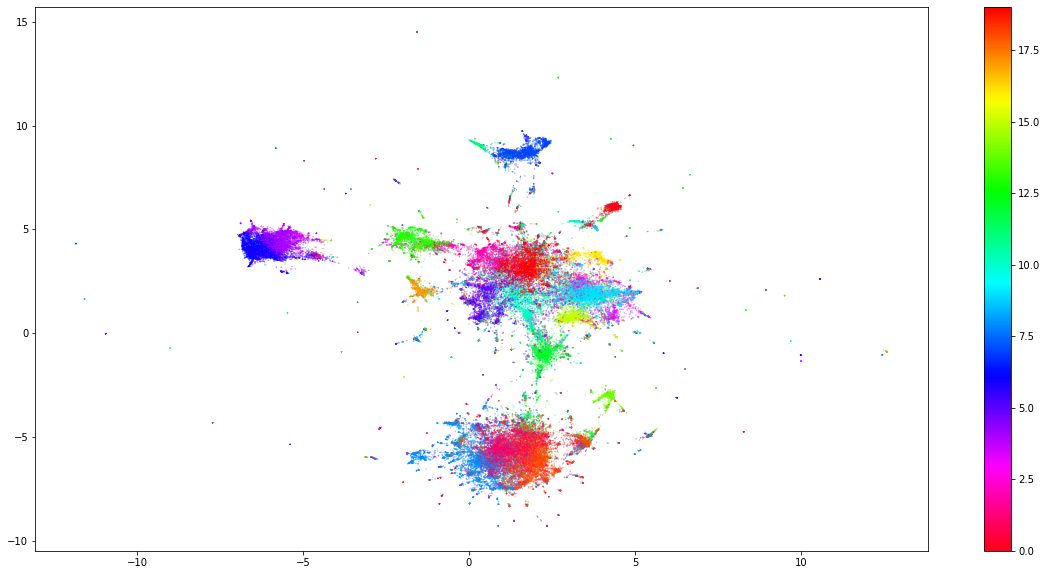

In [24]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clustering_model_20.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

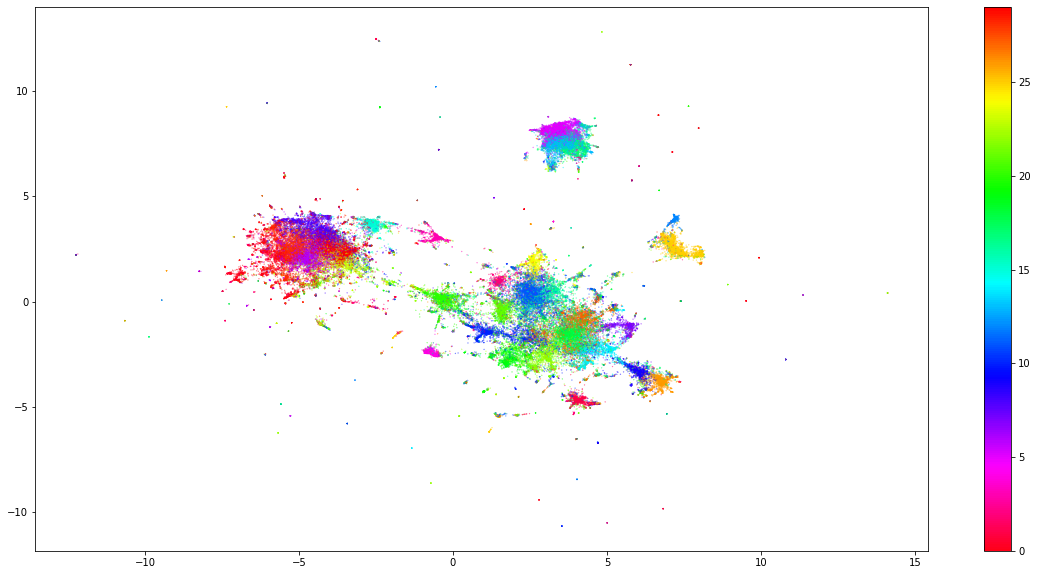

In [25]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clustering_model_30.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()